In [1]:
# Loading required libraries and initializing
from langdetect import DetectorFactory
from pandas import Series, DataFrame
from string import punctuation
#from numpy import zeros
#from pickle import dump
#from os import chdir

In [2]:
# Loading custom defined functions
#wd = open('wd.cfg').read()
#chdir(wd)
from tokenization import tokenize_sentence_nltk#, tokenize_treetagger
from util import read_file, flatten_list_of_list, read_folder#, clean_sentences
from util import pick_first_language, is_english_wp_p, spell_correct_tokens
from util import detect_language, clean_strings, run_treetagger
from util import filter_data, filter_senders, filter_recipients
from pos_tagging import run_treetagger_pos_tag_text
from modeling import apply_bigram_trigram_model
from lemmatization import lemmatize_treetagger
#from modeling import run_word2vec_model, run_lda_topic_model, build_logistic_regression
#from visualizing import visualize_word2vec_model

In [3]:
DetectorFactory.seed = 0

in_file = open("in_file.cfg").read()
in_file = in_file.split("\n")
file_folder = in_file[4]
label = in_file[3]
col = in_file[2]
in_type = in_file[1]
in_file = in_file[0]
if file_folder == "file":
    strings = read_file(in_file, in_type = in_type)
    if in_type == "text":
        strings = tokenize_sentence_nltk(strings)
        strings = DataFrame(strings)[0]
    elif in_type == "html":
        timestamp = strings[2]
        meta_data = strings[1]
        strings = strings[0]
        strings[label] = meta_data["Comment"]
        labels = strings[label]
        strings = strings[col]
    else:
        if label in strings.columns:
            labels = strings[label]
        strings = strings[col]
else:
    strings = read_folder(in_file, in_type = in_type)

NLP\33137034_copy.html
<class 'pandas.core.frame.DataFrame'>
NLP\derby.log
<class 'pandas.core.frame.DataFrame'>
NLP\HTML
NLP\HTML\33137034_copy - Copy.html
<class 'pandas.core.frame.DataFrame'>
NLP\HTML\33137034_copy.html
<class 'pandas.core.frame.DataFrame'>
NLP\pysparktest.ipynb
<class 'pandas.core.frame.DataFrame'>
NLP\Sample.csv
<class 'pandas.core.frame.DataFrame'>
NLP\Sample.xlsx
<class 'pandas.core.frame.DataFrame'>
NLP\Try.csv
<class 'pandas.core.frame.DataFrame'>


In [4]:
# Some deduplication to be done here to keep the remaining steps same
strings = filter_data(strings)
strings = filter_senders(strings)
strings = filter_recipients(strings)
strings1 = strings.drop(['df'], axis = 1).reset_index()
strings = strings['df'].apply(lambda x: ". ".join(x['Message']).replace("..", ".")).reset_index()['df']
from pandas import concat
strings1 = concat([strings, strings1], axis = 1)
strings1.to_csv("strings_with_meta_data.csv")

ValueError: cannot insert timestamp, already exists

In [5]:
strings

,df,participants,timestamp,language,sender,recipients,conversation_length
0,Sent Time (CEST) Network Message I...,person2 (zun)person1 (tbl);person2 (zun)nan,"date dienstag, 13. juni 2017 14:30",en,person2 (zun),"[person1 (tbl), person2 (zun), nan]",12
0,Sent Time (CEST) Network Message I...,person2 (zun)person1 (tbl);person2 (zun)nan,"date dienstag, 13. juni 2017 14:30",en,person2 (zun),"[person1 (tbl), person2 (zun), nan]",12
0,Sent Time (CEST) Network Message I...,person2 (zun)person1 (tbl);person2 (zun)nan,"date dienstag, 13. juni 2017 14:30",en,person2 (zun),"[person1 (tbl), person2 (zun), nan]",12


In [4]:
# Picking the language with highest probability
first_language = languages.apply(pick_first_language)

In [5]:
# Keeping only English text
english_only = first_language.apply(is_english_wp_p)
strings = strings[english_only]
labels = labels[english_only].tolist()

In [6]:
# Processing English sentences:
# 1) Splitting sentences
sentences = strings.apply(tokenize_sentence_nltk)
lengths = sentences.apply(len).tolist()
new_labels = []
for i in range(len(lengths)):
    for j in range(lengths[i]):
        new_labels.append(labels[i])
new_labels = Series(new_labels)
sentences1 = flatten_list_of_list(sentences)

In [7]:
# 2) Run part-of-speech tagging on clean sentences
sentences1 = Series(sentences1)
pos = sentences1.apply(run_treetagger_pos_tag_text).apply(DataFrame)

In [8]:
# 3) Spell correct - currently correct only disjoint words
lengths = pos.apply(len)
inc_sentences = sentences1[lengths == 0]
inc_labels = new_labels[lengths == 0]
pos = pos[lengths > 0]
labels = new_labels[lengths > 0]
sentence_tokens = pos.apply(spell_correct_tokens)

In [9]:
# 4) Combine tokens to form bigrams and trigrams
# sentence_tokens = sentences.apply(tokenize_treetagger)
trigrams = apply_bigram_trigram_model(sentence_tokens)

In [10]:
# 5) Form the sentence back from tokens
sentences1 = ["".join([" "+i if not i.startswith("'") and i not in punctuation
                       else i for i in tokens]).strip() for tokens in trigrams]
sentences1 = sentences1 + inc_sentences.tolist()
labels = labels.tolist() + inc_labels.tolist()

In [17]:
from re import sub
sentences1 = [sub("â\x80\x99", "'", sentence) for sentence in sentences1]
sentences1

['are we ok with keeping this as is.',
 'ie the info lvls& risk sharing?.',
 'that is the qu.',
 "dont want other numpty's in mkt to know.",
 'but not only that.',
 'is he gonna protect us.',
 'like we protect each other against our own branches.',
 'and my nyk is lhs.',
 "what concerns me is that i know he'll never tell us when at risk ..."]

In [44]:
from gensim.models.word2vec import LineSentence, Word2Vec
sentences = LineSentence("sample.txt")

In [45]:
model = Word2Vec(sentences, sg=1,workers=5,size=100,min_count=2,window=5)

In [34]:
model.build_vocab(sentences)

RuntimeError: cannot sort vocabulary after model weights already initialized.

In [46]:
model.train(sentences, total_examples = model.corpus_count, epochs = 20)

6236

In [47]:
# 6) Write clean text to text file - one line per sentence
out_file = open("sample.txt", "w")
for sent in sentences1:
    out_file.write(sent.lower().replace("( ", "(").replace(" )", ")").replace("replaced-dns ", "")+"\n")
out_file.close()

In [19]:
# 7) Run word2vec model and store word representations
model = run_word2vec_model("sample.txt")
model.wv.save_word2vec_format("big.w2v")

RuntimeError: you must first build vocabulary before training the model

In [48]:
model.wv.save_word2vec_format("big.w2v")

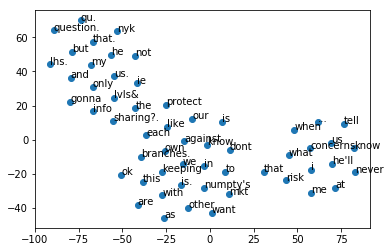

In [52]:
# 8) Visualizing the word2vec model
visualize_word2vec_model(model)

In [ ]:
# 9) Setting up the data for building logistic regression model
df = zeros((len(sentences1), 100))
for i, words in enumerate(trigrams):
    for word in words:
        try:
            df[i] = df[i] + model[word]
        except:
            continue

while(i<len(sentences1)):
    i += 1

df = DataFrame(df)
df[label] = labels

In [ ]:
# 10) Building and saving the logistic regression model with L1 penalty
lr_model = build_logistic_regression(df, label)
dump(lr_model, open("logistic_model.pkl", 'wb'))

In [60]:
# 11) Topic modeling (Optional)
lda_model = run_lda_topic_model(text_file = "sample.txt")
# Sample topic modeling output - Topic 1
for i in range(3):
    print(lda_model.print_topic(i+1))

0.046*"us" + 0.046*"protect" + 0.046*"gonna" + 0.037*"branches" + 0.037*"nyk" + 0.037*"tell" + 0.037*"like" + 0.037*"never" + 0.037*"lhs" + 0.037*"'ll"
0.038*"nyk" + 0.038*"concerns" + 0.038*"us" + 0.038*"like" + 0.038*"branches" + 0.038*"gonna" + 0.038*"lhs" + 0.038*"tell" + 0.038*"never" + 0.038*"mkt"
0.041*"nyk" + 0.041*"lhs" + 0.040*"us" + 0.039*"..." + 0.039*"concerns" + 0.039*"know" + 0.039*"tell" + 0.039*"risk" + 0.039*"never" + 0.039*"'ll"


In [61]:
from gensim import corpora
texts = open("sample_cleaned.txt", "r").read().split("\n")
texts = [text.split(" ") for text in texts]
dictionary = corpora.Dictionary(texts)
for i in range(10):
    try:
        text = dictionary.doc2bow(texts[i])
        print(lda_model.get_document_topics(bow = text))
    except:
        continue


[(20, 0.22333333333333374), (76, 0.11222222222222242), (83, 0.55666666666666775)]
[(38, 0.54636363636363694), (50, 0.24844080227303281), (92, 0.1170137431815131)]
[(57, 0.11222222222222226), (83, 0.55666666666666687), (91, 0.22333333333333341)]
[(38, 0.54636363636363705), (50, 0.24820067718922412), (92, 0.1172538682653218)]
